In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [30]:
from dipy.segment.templates import make_rb_template
import kesh_autoseg_tools as kat
import os
from glob import glob
import nibabel as nib
from IPython.display import Image
from dipy.tracking.utils import move_streamlines
import numpy as np

In [85]:
basepath = '/Users/kesshijordan/ref_data/control_manual_data/'

#Path to a whole-brain streamline dataset in MNI space
#https://figshare.com/articles/Simple_model_bundle_atlas_for_RecoBundles/6483614
MNI_wholebrain_trkfile_path = '/Users/kesshijordan/ref_data/Atlas_in_MNI_Space_16_bundles/whole_brain/whole_brain_MNI.trk'

#The Keystone subject will be used to map between your cohort and MNI space
Keystone_subject_wholebrain_trkfile_path = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Base_CTRL/Whole_Brain_long_resaved_newapi.trk'
#Also include the bundle of interest (BOI) segmented in the Keystone subject

In [5]:
def get_paths(basepath, TOI):
    
    putpath = os.path.join(basepath, 'templates/'+TOI)

    Keystone_subject_BOI_trkfile_path = '/Users/kesshijordan/Desktop/IU_Bloomington/qb_templates/Base_CTRL/Results/'+TOI

    filelist = glob(os.path.join(basepath, 'C*/'+TOI))
    
    return putpath, Keystone_subject_BOI_trkfile_path, filelist

In [6]:
def loadtrk(trkpath):
    tg, hdr = kat.loadtgm_newapi(trkpath)
    sls = tg.streamlines
    return sls, hdr, tg

In [7]:
def load_trk_list(path_list):
    bundle_list = []
    for p in path_list:
        tg, hdr = kat.loadtgm_newapi(p)
        sls = tg.streamlines
        bundle_list.append(sls)
    return bundle_list

In [8]:
def save_trk(sls, aff, savepath):
    tgm = nib.streamlines.tractogram.Tractogram(streamlines=sls, affine_to_rasmm=aff)
    nib.streamlines.save(tgm, savepath)

In [33]:
from dipy.tracking.utils import length
from dipy.tracking.distances import bundles_distances_mdf
from dipy.tracking.streamline import set_number_of_points

def calculate_cci(streamlines, max_mdf=5, subsample=12, power=1):
    '''THIS IS IN A WIP PR'''
    #remove any streamlines that are shorter than the min_sl_length
    lengths = list(length(streamlines))
    if np.array(lengths).min()<20:
        print('Check your streamline lengths. There are many short streamlines!')

    #calculate the pairwise MDF distance between all streamlines in dataset that are longer than min_sl_length
    subsamp_sls = set_number_of_points(streamlines, subsample)

    cci_score_mtrx = np.zeros([len(subsamp_sls)])

    for i,sl in enumerate(subsamp_sls):
        mdf_mtrx = bundles_distances_mdf([subsamp_sls[i]], subsamp_sls)
        mdf_mtrx_oi = (mdf_mtrx > 0) & (mdf_mtrx < max_mdf) & ~ np.isnan(mdf_mtrx)
        mdf_mtrx_oi_only = mdf_mtrx[mdf_mtrx_oi]
        cci_score = np.sum(np.divide(1, np.power(mdf_mtrx_oi_only, power)))
        cci_score_mtrx[i] = cci_score

    return cci_score_mtrx

def filter_cci(sls, cci_vector, thr=1):
    new_sls = []
    rejected = []
    for i, sl in enumerate(sls):
        if cci_vector[i]>thr:
            new_sls.append(sl)
        else:
            rejected.append(sl)
    return new_sls, rejected

In [10]:
mni_sls, mni_hdr, mni_tg = loadtrk(MNI_wholebrain_trkfile_path)

In [11]:
key_sls, key_hdr, key_tg  = loadtrk(Keystone_subject_wholebrain_trkfile_path)

In [12]:
keystone_inMNI, transform_key2mni, qb_cents1, qb_cents2 = kat.rough_reg(mni_sls, key_sls)

Static streamlines size 144678
Moving streamlines size 108379
Static streamlines after length reduction 123874
Moving streamlines after length reduction 91351
Progressive Registration is Enabled
 Translation  (3 parameters)...
 Rigid  (6 parameters) ...
 Similarity (7 parameters) ...
 Scaling (9 parameters) ...
 Affine (12 parameters) ...
QB static centroids size 231
QB moving centroids size 330
SLR finished in  8.277 seconds.
SLR iterations: 53 


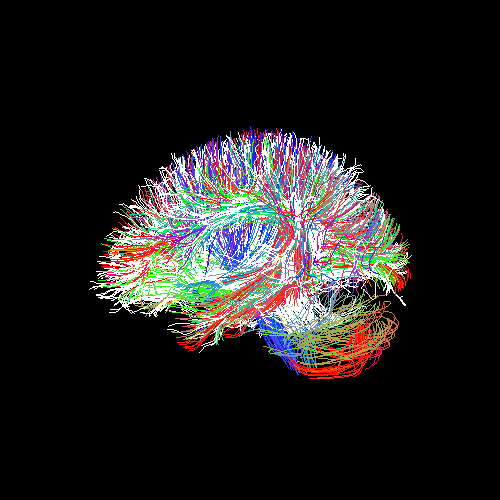

In [19]:
Image(kat.genren_AGG(mni_sls[::100], keystone_inMNI[::100]))

In [20]:
def load_toi_components(basepath, trkname):
    putpath, Keystone_subject_BOI_trkfile_path, filelist = get_paths(basepath, trkname)
    kboi_sls, kboi_hdr, kboi_tg = loadtrk(Keystone_subject_BOI_trkfile_path)
    bundlelist = load_trk_list(filelist)
    return putpath, kboi_sls, bundlelist

In [21]:
#putpath, kboi_sls, bundlelist = load_toi_components(basepath, 'Arcuate_L.trk')

In [127]:
def make_template(bundle_list, keystone_boi, transform_key2mni, mni_aff, putpath):

    template_sls, rejected_sls, template_labels = make_rb_template(bundle_list, 
                                                                   keystone_boi)
    
    template_sls_mni = list(move_streamlines(template_sls, transform_key2mni))

    save_trk(template_sls_mni, mni_aff, putpath.replace('.trk','_raw.trk'))
    
    ccis = calculate_cci(template_sls_mni)
    
    cci_sls, cci_reject = filter_cci(template_sls_mni, ccis, thr=0.5)
    
    save_trk(cci_sls, mni_aff, putpath.replace('.trk','_ccipt5.trk'))

In [68]:
trk_list = ['Arcuate_L.trk','Arcuate_R.trk','IFOF_L.trk','IFOF_R.trk', 'Uncinate_L.trk', 'Uncinate_R.trk', 'SLF_IP_L.trk', 'SLF_IP_R.trk', 'SLF_tp_L.trk', 'SLF_tp_R.trk']

In [66]:
def mybatch(basepath, trk_list, transform_key2mni, mni_tg):
    for trkname in trk_list:
        print(trkname)
        putpath, kboi_sls, bundlelist = load_toi_components(basepath, trkname)
        make_template(bundlelist, kboi_sls, transform_key2mni, mni_tg.affine_to_rasmm, putpath) 
        

In [67]:
mybatch(basepath, trk_list[4:], transform_key2mni, mni_tg)

Uncinate_L.trk
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
Uncinate_R.trk
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [78]:
mybatch(basepath, trk_list[-1:], transform_key2mni, mni_tg)

SLF_tp_R.trk
10 2531 [[ 9.96734720e-01 -8.58431557e-02  1.45036655e-02  3.25758942e+00]
 [ 2.93554983e-02  9.58320824e-01  1.76116257e-01 -4.23107375e+01]
 [-2.44239307e-02 -1.37013576e-01  9.62673273e-01 -1.65916356e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] /Users/kesshijordan/ref_data/control_manual_data/templates/SLF_tp_R.trk
10
9
8
7
6
5
4
3
2
1


In [79]:
mybatch(basepath, trk_list[-2:-1], transform_key2mni, mni_tg)

SLF_tp_L.trk
10 4935 [[ 9.96734720e-01 -8.58431557e-02  1.45036655e-02  3.25758942e+00]
 [ 2.93554983e-02  9.58320824e-01  1.76116257e-01 -4.23107375e+01]
 [-2.44239307e-02 -1.37013576e-01  9.62673273e-01 -1.65916356e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] /Users/kesshijordan/ref_data/control_manual_data/templates/SLF_tp_L.trk
10
9
8
7
6
5
4
3
2
1


In [111]:
template_path = '/Users/kesshijordan/ref_data/control_manual_data/templates/'
Ltemplates = glob(os.path.join(template_path, '*L_raw.trk'))
Ltemplates_cci = glob(os.path.join(template_path, '*L_ccipt5.trk'))
print(Ltemplates)
print(Ltemplates_cci)

['/Users/kesshijordan/ref_data/control_manual_data/templates/Uncinate_L_raw.trk', '/Users/kesshijordan/ref_data/control_manual_data/templates/IFOF_L_raw.trk', '/Users/kesshijordan/ref_data/control_manual_data/templates/SLF_tp_L_raw.trk', '/Users/kesshijordan/ref_data/control_manual_data/templates/Arcuate_L_raw.trk', '/Users/kesshijordan/ref_data/control_manual_data/templates/SLF_IP_L_raw.trk']
['/Users/kesshijordan/ref_data/control_manual_data/templates/IFOF_L_ccipt5.trk', '/Users/kesshijordan/ref_data/control_manual_data/templates/SLF_tp_L_ccipt5.trk', '/Users/kesshijordan/ref_data/control_manual_data/templates/Uncinate_L_ccipt5.trk', '/Users/kesshijordan/ref_data/control_manual_data/templates/Arcuate_L_ccipt5.trk', '/Users/kesshijordan/ref_data/control_manual_data/templates/SLF_IP_L_ccipt5.trk']


In [112]:
Lraw = load_trk_list(Ltemplates)
Lcci = load_trk_list(Ltemplates_cci)

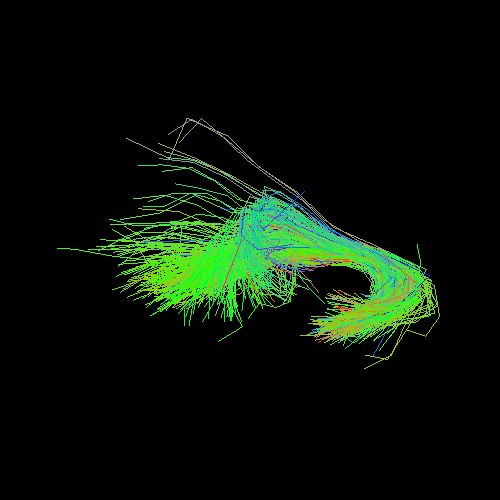

In [118]:
Image(kat.genren_AGG(Lraw[0], showme=True))

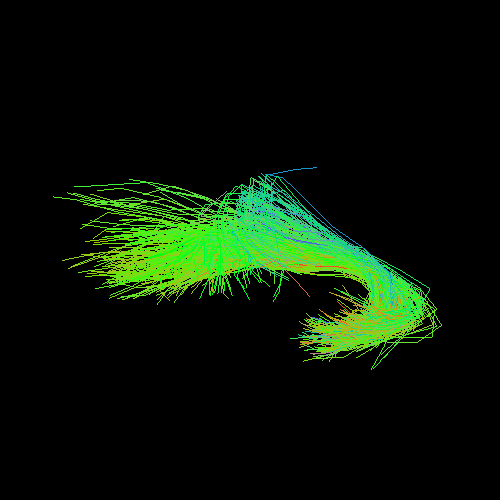

In [125]:
Image(kat.genren_AGG(Lcci[2], showme=True))

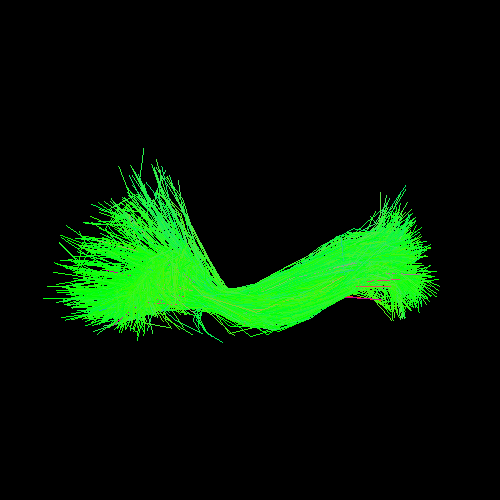

In [115]:
Image(kat.genren_AGG(Lraw[1], showme=True))

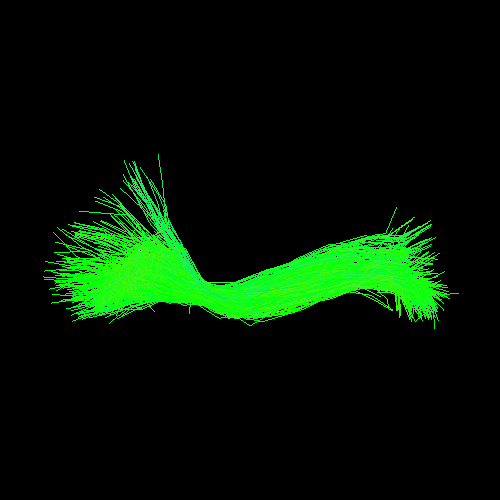

In [117]:
Image(kat.genren_AGG(Lcci[0], showme=True))

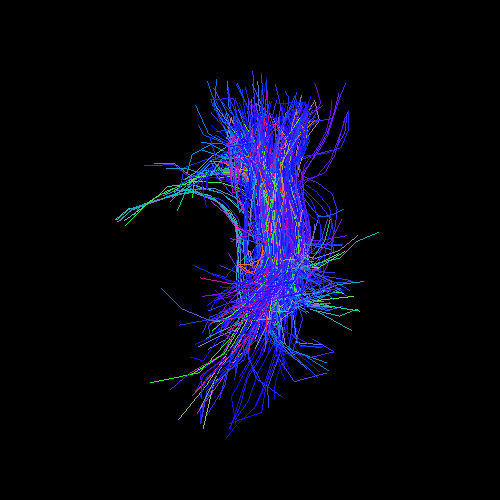

In [103]:
Image(kat.genren_AGG(Lraw[2]))

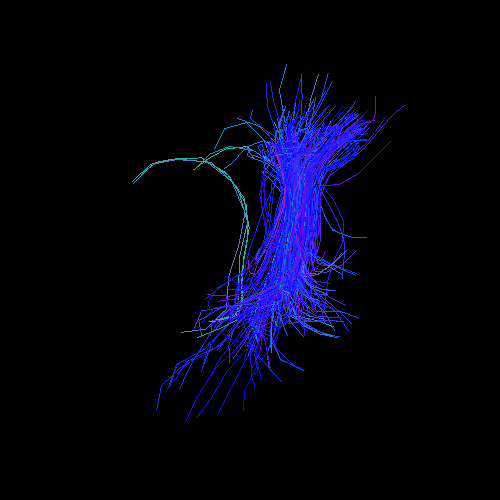

In [121]:
Image(kat.genren_AGG(Lcci[1], showme=True))

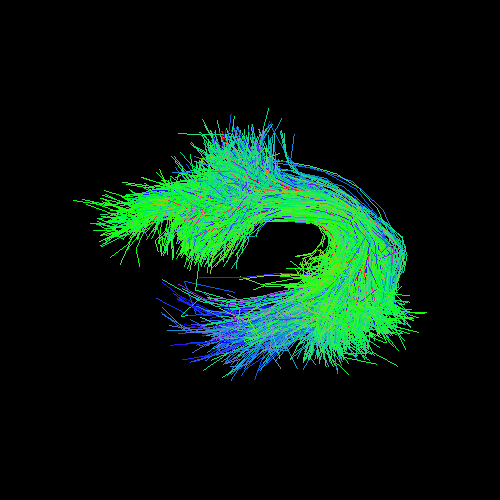

In [105]:
Image(kat.genren_AGG(Lraw[3], showme=True))

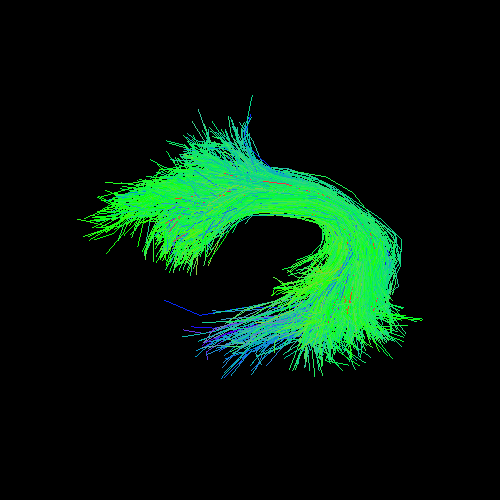

In [126]:
Image(kat.genren_AGG(Lcci[3], showme=True))